<a href="https://colab.research.google.com/github/vishwas14/Face-Mask-Detection/blob/main/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [55]:
dataset = pd.read_csv(r'BSME.csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,16-10-2019,38637.05078,38666.37891,38416.67188,38598.98828,38598.98828,27500.0
1,17-10-2019,38647.44141,39104.69141,38557.42969,39052.05859,39052.05859,47100.0
2,18-10-2019,39087.82813,39361.05859,38963.60156,39298.37891,39298.37891,42400.0
3,22-10-2019,39233.39844,39426.46875,38924.85156,38963.83984,38963.83984,54500.0
4,23-10-2019,39063.83984,39196.67188,38866.07813,39058.82813,39058.82813,41000.0


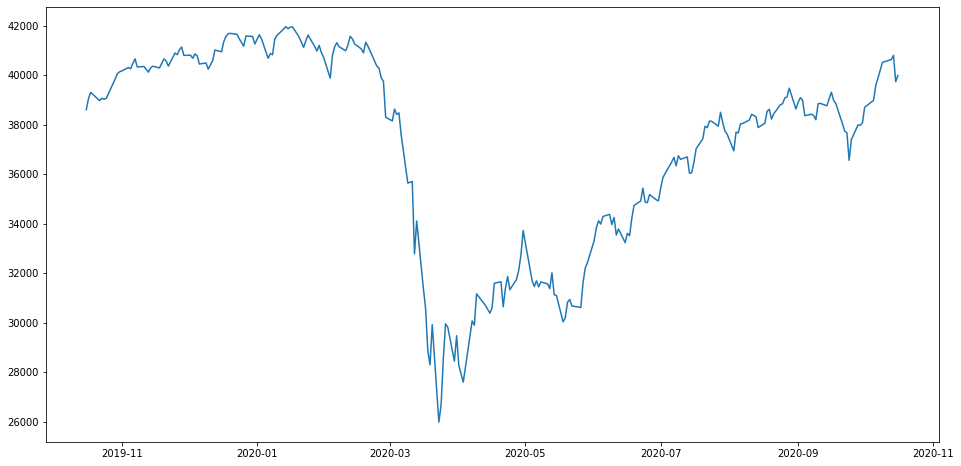

In [56]:
dataset['Date'] = pd.to_datetime(dataset.Date,format='%d-%m-%Y')
dataset.index = dataset['Date']
dataset.dropna(inplace=True)
#plot
plt.figure(figsize=(16,8))
plt.plot(dataset['Close'], label='Close Price history')

In [57]:
np.random.seed(7)

In [58]:
closing_data = pd.read_csv('BSME.csv', usecols=[5])
closing_data.dropna(inplace=True)
closing_data = closing_data.values
closing_data = closing_data.astype('float32')

In [59]:
def create_dataset(closing_data, look_back=1):
	dataX, dataY = [], []
	for i in range(len(closing_data)-look_back-1):
		a = closing_data[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(closing_data[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [60]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
closing_data = scaler.fit_transform(closing_data)

In [61]:
# split into train and test sets
train_size = int(len(closing_data) * 0.70)
test_size = len(closing_data) - train_size
train, test = closing_data[0:train_size,:], closing_data[train_size:len(closing_data),:]

In [62]:

# reshape into X=t and Y=t+1
look_back = 3
xtrain, ytrain = create_dataset(train, look_back)
xtest, ytest = create_dataset(test, look_back)
#reshape input to be [samples, time steps, features]
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

In [63]:
print(xtrain[0])
print(ytrain[0])

[[0.790022  ]
 [0.81838953]
 [0.8338121 ]]
0.8128661


In [64]:
model = Sequential()
model.add(LSTM(7, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xtrain, ytrain, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
170/170 - 2s - loss: 0.0557
Epoch 2/100
170/170 - 0s - loss: 0.0067
Epoch 3/100
170/170 - 0s - loss: 0.0042
Epoch 4/100
170/170 - 0s - loss: 0.0032
Epoch 5/100
170/170 - 0s - loss: 0.0030
Epoch 6/100
170/170 - 0s - loss: 0.0029
Epoch 7/100
170/170 - 0s - loss: 0.0029
Epoch 8/100
170/170 - 0s - loss: 0.0030
Epoch 9/100
170/170 - 0s - loss: 0.0030
Epoch 10/100
170/170 - 0s - loss: 0.0030
Epoch 11/100
170/170 - 0s - loss: 0.0030
Epoch 12/100
170/170 - 0s - loss: 0.0030
Epoch 13/100
170/170 - 0s - loss: 0.0030
Epoch 14/100
170/170 - 0s - loss: 0.0029
Epoch 15/100
170/170 - 0s - loss: 0.0030
Epoch 16/100
170/170 - 0s - loss: 0.0029
Epoch 17/100
170/170 - 0s - loss: 0.0030
Epoch 18/100
170/170 - 0s - loss: 0.0029
Epoch 19/100
170/170 - 0s - loss: 0.0029
Epoch 20/100
170/170 - 0s - loss: 0.0029
Epoch 21/100
170/170 - 0s - loss: 0.0028
Epoch 22/100
170/170 - 0s - loss: 0.0029
Epoch 23/100
170/170 - 0s - loss: 0.0028
Epoch 24/100
170/170 - 0s - loss: 0.0029
Epoch 25/100
170/170 - 0s

In [65]:
# make predictions
train_predict = model.predict(xtrain)
test_predict = model.predict(xtest)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
ytrain = scaler.inverse_transform([ytrain])
test_predict = scaler.inverse_transform(test_predict)
ytest = scaler.inverse_transform([ytest])


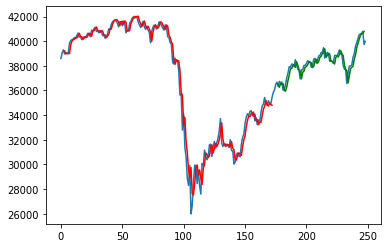

In [66]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(closing_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
test_predict_plot = np.empty_like(closing_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(closing_data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(closing_data))
plt.plot(train_predict_plot,color='red')
plt.plot(test_predict_plot,color='green')
plt.show()

In [69]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(ytrain[0], train_predict[:,0]))
print("Root mean square error (train score) = ",train_score," RMSE")
test_score = math.sqrt(mean_squared_error(ytest[0], test_predict[:,0]))
print("Root mean square error (test score) = ",test_score," RMSE")

Root mean square error (train score) =  710.4679337327401  RMSE
Root mean square error (test score) =  435.77986451985805  RMSE


In [70]:
columns = ['Date','Category','Headlines']
news_data = pd.read_csv(r'YahooNewsHeadlines.csv', names = columns)
news_data.head()

,Date,Category,Headlines
0,publish_date,headline_category,headline_text
1,20010101,sports.wwe,win over cena satisfying but defeating underta...
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?


In [71]:
news_data.head()

,Date,Category,Headlines
0,publish_date,headline_category,headline_text
1,20010101,sports.wwe,win over cena satisfying but defeating underta...
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?


In [72]:
news_data.drop(0, inplace=True)
news_data.drop('Category', axis = 1, inplace=True)
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206506 entries, 1 to 206506
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Date       206506 non-null  object
 1   Headlines  206506 non-null  object
dtypes: object(2)
memory usage: 4.7+ MB


In [73]:
# Restructuring the date format
news_data['Date'] = pd.to_datetime(news_data['Date'],format= '%Y %m %d')
news_data.head()

,Date,Headlines
1,2001-01-01,win over cena satisfying but defeating underta...
2,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
3,2001-01-02,Fissures in Hurriyat over Pak visit
4,2001-01-02,America's unwanted heading for India?
5,2001-01-02,For bigwigs; it is destination Goa


In [74]:
#Grouping the headlines for each day
news_data['Headlines'] = news_data.groupby(['Date']).transform(lambda x : ' '.join(x)) 
news_data = news_data.drop_duplicates() 
news_data.reset_index(inplace = True, drop = True)
news_data

,Date,Headlines
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-03,Powerless north India gropes in the dark Think...
3,2001-01-04,The string that pulled Stephen Hawking to Indi...
4,2001-01-05,Light combat craft takes India into club class...
...,...,...
815,2003-05-07,Ahmedabad's Date with Scintillating Shankar! Z...
816,2003-05-08,A-I to be fully operational soon: Naik Goa to ...
817,2003-05-09,SACRED SPACEBRTalking Peace THE SPEAKING TREEB...
818,2003-05-10,Citizen's initiative sought to improve city's ...


In [75]:
  news_data['Headlines']

0      win over cena satisfying but defeating underta...
1      Status quo will not be disturbed at Ayodhya; s...
2      Powerless north India gropes in the dark Think...
3      The string that pulled Stephen Hawking to Indi...
4      Light combat craft takes India into club class...
                             ...                        
815    Ahmedabad's Date with Scintillating Shankar! Z...
816    A-I to be fully operational soon: Naik Goa to ...
817    SACRED SPACEBRTalking Peace THE SPEAKING TREEB...
818    Citizen's initiative sought to improve city's ...
819    Cricket will always be my first love: Jadeja H...
Name: Headlines, Length: 820, dtype: object

In [76]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [77]:
#Adding subjectivity and polarity columns
news_data['Subjectivity'] = news_data['Headlines'].apply(getSubjectivity)
news_data['Polarity'] = news_data['Headlines'].apply(getPolarity)
news_data

,Date,Headlines,Subjectivity,Polarity
0,2001-01-01,win over cena satisfying but defeating underta...,0.633333,0.433333
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
2,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462
3,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
4,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024
...,...,...,...,...
815,2003-05-07,Ahmedabad's Date with Scintillating Shankar! Z...,0.407296,0.056276
816,2003-05-08,A-I to be fully operational soon: Naik Goa to ...,0.428932,0.088639
817,2003-05-09,SACRED SPACEBRTalking Peace THE SPEAKING TREEB...,0.391827,0.103137
818,2003-05-10,Citizen's initiative sought to improve city's ...,0.415763,0.087931


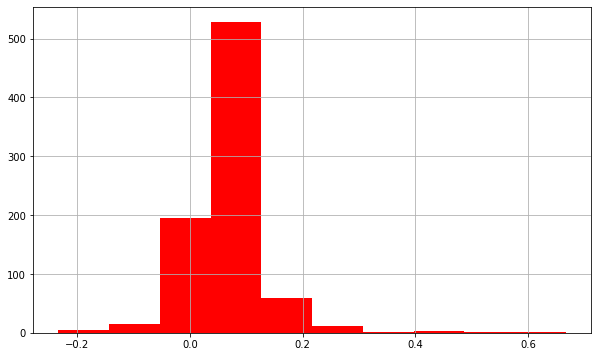

In [78]:
plt.figure(figsize = (10,6))
news_data['Polarity'].hist(color = 'red')

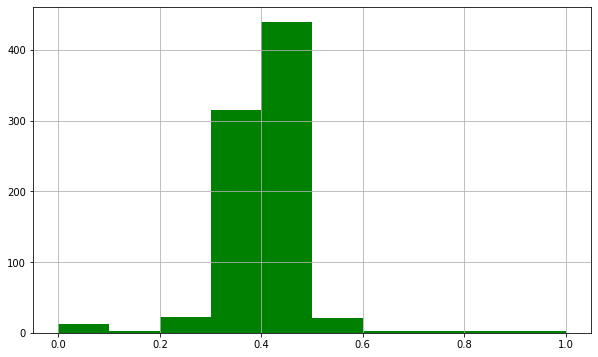

In [79]:
plt.figure(figsize = (10,6))
news_data['Subjectivity'].hist(color = 'green')

In [80]:
#Adding sentiment score to news
sia = SentimentIntensityAnalyzer()

news_data['Compound'] = [sia.polarity_scores(v)['compound'] for v in news_data['Headlines']]
news_data['Negative'] = [sia.polarity_scores(v)['neg'] for v in news_data['Headlines']]
news_data['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news_data['Headlines']]
news_data['Positive'] = [sia.polarity_scores(v)['pos'] for v in news_data['Headlines']]
news_data

,Date,Headlines,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-01,win over cena satisfying but defeating underta...,0.633333,0.433333,-0.0000,0.230,0.473,0.297
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
2,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
3,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
4,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024,0.9633,0.124,0.722,0.154
...,...,...,...,...,...,...,...,...
815,2003-05-07,Ahmedabad's Date with Scintillating Shankar! Z...,0.407296,0.056276,-0.9985,0.151,0.739,0.109
816,2003-05-08,A-I to be fully operational soon: Naik Goa to ...,0.428932,0.088639,-0.9994,0.176,0.713,0.111
817,2003-05-09,SACRED SPACEBRTalking Peace THE SPEAKING TREEB...,0.391827,0.103137,-0.9911,0.142,0.731,0.127
818,2003-05-10,Citizen's initiative sought to improve city's ...,0.415763,0.087931,-0.9993,0.154,0.756,0.090


In [81]:
merge = news_data
dff = merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
dff

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.633333,0.433333,-0.0000,0.230,0.473,0.297
1,0.282333,0.151333,-0.9811,0.122,0.807,0.071
2,0.407692,0.088462,-0.2640,0.122,0.766,0.111
3,0.446847,0.087961,0.8738,0.100,0.797,0.103
4,0.476612,0.262024,0.9633,0.124,0.722,0.154
...,...,...,...,...,...,...
815,0.407296,0.056276,-0.9985,0.151,0.739,0.109
816,0.428932,0.088639,-0.9994,0.176,0.713,0.111
817,0.391827,0.103137,-0.9911,0.142,0.731,0.127
818,0.415763,0.087931,-0.9993,0.154,0.756,0.090


In [82]:
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(dff))
new_df.columns = dff.columns
new_df.index = dff.index
new_df.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.633333,0.740741,0.500576,0.518018,0.473,0.488487
1,0.282333,0.427407,0.009412,0.274775,0.807,0.116776
2,0.407692,0.357550,0.368411,0.274775,0.766,0.182566
3,0.446847,0.356994,0.938023,0.225225,0.797,0.169408
4,0.476612,0.550397,0.982829,0.279279,0.722,0.253289


In [83]:
X = new_df[0:249]
y =dataset['Close']

In [84]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(199, 6)

In [85]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
108,0.405833,0.540833,0.025081,0.373874,0.734,0.164474
18,0.375486,0.391781,0.099975,0.364865,0.709,0.212171
205,0.433601,0.297440,0.003805,0.272523,0.772,0.175987
15,0.383333,0.339506,0.978173,0.171171,0.780,0.235197
71,0.344118,0.308279,0.008360,0.522523,0.616,0.250000
7,0.414653,0.237911,0.011014,0.272523,0.812,0.108553
228,0.358700,0.246596,0.000300,0.362613,0.772,0.111842
180,0.419285,0.357075,0.000701,0.265766,0.808,0.121711
146,0.750000,0.814815,0.836245,0.121622,0.765,0.297697
160,0.338659,0.281909,0.000451,0.351351,0.777,0.110197


In [86]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [87]:
print(prediction[:10])
print(y_test[:10])
print("Root mean square error = ",math.sqrt(mean_squared_error(prediction,y_test))," RMSE")

[35995.1661339  37186.6857241  38663.1114666  37150.02894137
 36585.00793278 39624.4682615  38872.9163876  35429.2587126
 38842.9136737  38007.1623649 ]
Date
2020-10-16    39982.98047
2020-06-25    34842.10156
2020-02-06    41306.03125
2020-06-01    33303.51953
2020-05-22    30672.58984
2020-02-03    39872.30859
2019-12-23    41642.66016
2020-06-12    33780.89063
2020-09-03    38990.94141
2020-08-27    39113.46875
Name: Close, dtype: float64
Root mean square error =  4028.824278503002  RMSE


In [88]:
LR = LinearRegression()
LR.fit(x_train,y_train)
prediction=LR.predict(x_test)

In [89]:
print(prediction[:10])
print(y_test[:10])
print("Root mean square error = ",math.sqrt(mean_squared_error(prediction,y_test))," RMSE")

[37117.49811329 36992.08816627 37101.05181672 36950.70399162
 36418.87035761 38182.80114315 37168.86870671 36657.30047249
 37183.44831727 36078.11831388]
Date
2020-10-16    39982.98047
2020-06-25    34842.10156
2020-02-06    41306.03125
2020-06-01    33303.51953
2020-05-22    30672.58984
2020-02-03    39872.30859
2019-12-23    41642.66016
2020-06-12    33780.89063
2020-09-03    38990.94141
2020-08-27    39113.46875
Name: Close, dtype: float64
Root mean square error =  4045.3519050705563  RMSE
